# Object Detection
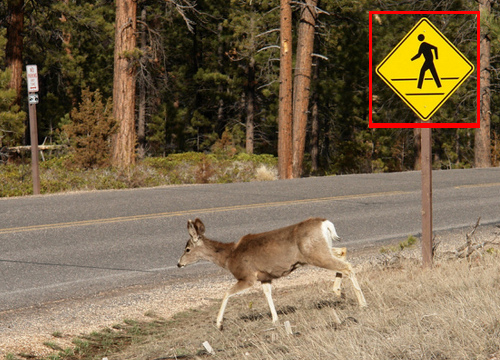

In [2]:
import numpy as np
import matplotlib.pyplot as plt

---
# Image Gradients 

In [3]:
#we will only use:  scipy.ndimage.correlate
from scipy import ndimage

def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters 
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    # [-1 1]

    sobel_x = [[-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1]]

    sobel_y = [[-1, -2,-1],
                [0, 0, 0],
                [1, 2, 1]]

    sobel_x = np.array(sobel_x)
    sobel_y = np.array(sobel_y)

    dx = ndimage.correlate(image, sobel_x, mode='nearest')
    dy = ndimage.correlate(image, sobel_y, mode='nearest')

    # edge strength
    mag = np.sqrt(dx**2 + dy**2) 

    # find gradient direction
    dx_buff = dx + 1e-16
    ori = np.arctan(dy / dx_buff)
    #theta = np.arctan(dy, dx)
    #ori = theta * -180 / np.pi
        
    return (mag,ori)

(515, 540)
(515, 540)


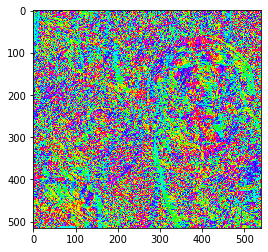

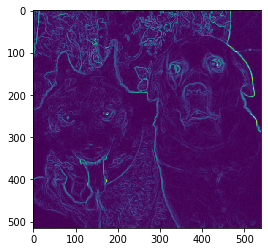

In [4]:
image = plt.imread("dogs.png")
image = np.average(image, axis=2)

print(image.shape)

(mag,ori) = mygradient(image)

print(mag.shape)

plt.imshow(ori, cmap=plt.cm.hsv)
plt.show()

plt.imshow(mag)
#visualize results mag,ori as images


---

# Histograms of Gradient Orientations
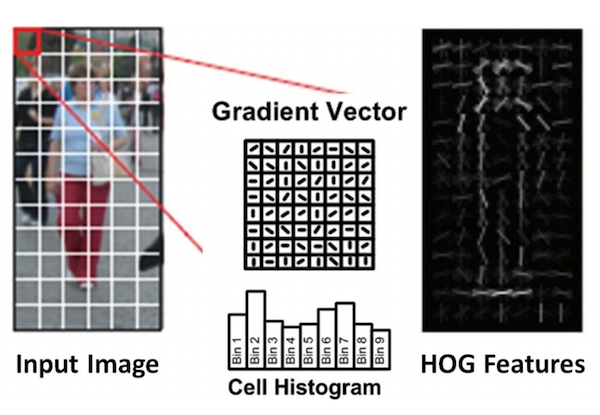

In [4]:
#we will only use:  ski.util.view_as_windows for computing hog descriptor
import skimage as ski   
def hog(image,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
        
    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram
        
    """   
    
    # determine the size of the HOG descriptor
    (h,w) = image.shape
    h2 = int(np.ceil(h/float(bsize)))
    w2 = int(np.ceil(w/float(bsize)))
    ohist = np.zeros((h2,w2,norient))
    
    # pad the input image on right and bottom as needed so that it 
    # is a multiple of bsize
    pw = (0, (w2 * bsize) - w)
    ph = (0, (h2 * bsize) - h)

    image = np.pad(image,(ph,pw),'symmetric')
    assert(image.shape==(h2*bsize,w2*bsize))
    
    # compute image gradients
    (mag,ori) = mygradient(image)
    # ori = (ori / 360) * np.pi;

    thresh = .1 * np.max(mag)

    # starting at -pi / 2, increase the angle by pi/norient every iteration
    # We add pi/norient to the angle since we are trying to classify
    # norient different types of edges
    start = np.pi / -2
    step = np.pi/ norient

    bincount = np.zeros((h2*bsize,w2*bsize))

    for i in range(norient):
        #create a binary image containing 1s for pixels at the ith 
        #orientation where the magnitude is above the threshold.
        B = np.zeros((h2*bsize, w2*bsize)) # make a base grid for the image

        """
        loop through all pixels within the input image

        if the edge at the current index
        is greater than the threshhold 
        and is within the range of the current orientation
        then set the corresponding pixel in the base grid to 1

        otherwise set the pixel to 0

        eg.
        start            = \_ (obtuse angle: 110 degrees)
        start + step     = /_ (acute angle:  75 degrees)
        ori[j,k]         = |_ (right angle:  90 degrees)

        ori[j.k] is between start and start + step
        since 75 < 90 < 110
        """
        for j in range(B.shape[0]):
            for k in range(B.shape[1]):
                if mag[j,k] > thresh and (ori[j,k] < (start + step) and ori[j,k] >= start):
                    B[j,k] = 1
                else:
                    B[j,k] = 0

        # add pi/9 to the current angle
        start = start + step
        bincount = bincount + B
        #pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B,(bsize,bsize),step=bsize)
    
        #sum up the count for each block and store the results
        # n = np.count_nonzero(chblock) 
        sums = np.count_nonzero(chblock, axis=(-1,-2)) # from piazza
        ohist[:,:,i] = sums # np.reshape(sums, (h2,w2))
       
    #each pixel should have only selected at most once
    assert(np.all(bincount<=1))

    # lastly, normalize the histogram so that the sum along the orientation dimension is 1
    for i in range(h2):
        for j in range(w2):
            k = np.sum(ohist[i, j]);
            if k != 0:
                ohist[i,j] = ohist[i,j] / k;


    
    assert(ohist.shape==(h2,w2,norient))
    
    return ohist

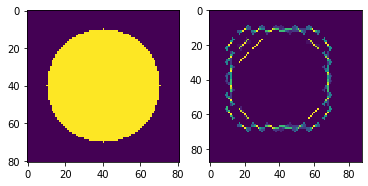

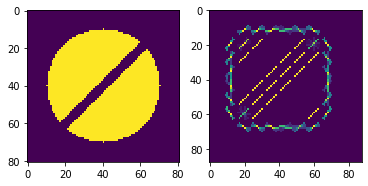

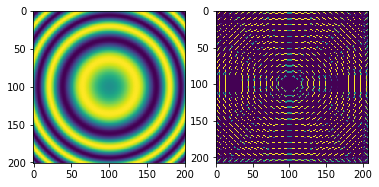

In [5]:
from hogvis import hogvis
np.set_printoptions(threshold=np.inf)
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)

o = hog(im)
hogim = hogvis(o)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()

[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)
im[np.abs(xx+yy)<=3] = 0
o = hog(im)
hogim = hogvis(o)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()


[yy,xx] = np.mgrid[-100:101,-100:101]
im = np.array(np.sin((xx*xx+yy*yy)/800),dtype=float)
o = hog(im)
hogim = hogvis(o)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()


---
# Detection

In [6]:
#we will only use:  scipy.ndimage.correlate
from scipy import ndimage
def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """   
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)
    
    print(image.shape)
    
    #cross-correlate the template with the feature map to get the total response
    # print(fmap.shape)     # 10 x 20 x 9
    # print(template.shape) # 3 x 3 x 9
    resp = np.zeros((fmap.shape[0], fmap.shape[1]))
    print(resp.shape)
    for i in range(norient):
        # print(template[:,:,i].shape, fmap[:,:,i].shape)
        resp = resp + ndimage.correlate(fmap[:,:,i], template[:,:,i])

    #sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
    val = np.sort(resp.flatten())[::-1]  #sorted response values
    ind = np.argsort(resp.flatten())[::-1]  #corresponding indices

    # print(val)
    # print(ind)
    #work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []

    # threshholds for overlaps
    wthresh = int(template.shape[0] * .7)
    hthresh = int(template.shape[1] * .7)

    while ((detcount < ndetect) and (i < len(val))):
        # convert 1d index into 2d index
        # t = np.unravel_index(ind[i], fmap.shape)
        yb = int(ind[i] / resp.shape[1])
        xb = int(ind[i] % resp.shape[1])
    
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        #covert block index to pixel coordinates based on bsize
        xp = xb * bsize
        yp = yb * bsize
    
        #check if this detection overlaps any detections that we've already added
        #to the list. compare the x,y coordinates of this detection to the x,y 
        #coordinates of the detections already in the list and see if any overlap
        #by checking if the distance between them is less than 70% of the template
        # width/height
        overlap = False

        if i != 0:
            for det in detections:
                if (abs(xp - det[0]) < wthresh) or (abs(yp - det[1]) < hthresh):
                    overlap = True
                    break
      
        #if the detection doesn't overlap then add it to the list
        if not overlap:
            detcount = detcount + 1
            detections.append((xp,yp,val[i]))
        
        i=i+1
    
    if (len(detections) < ndetect):
        print('WARNING: unable to find ',ndetect,' non-overlapping detections')
        
    return detections

In [7]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        
    plt.show()

(80, 160)
(10, 20)


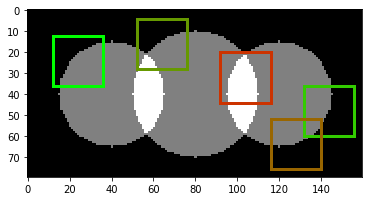

In [8]:
#create a synthetic image with some overlapping circles
[yy,xx] = np.mgrid[-40:40,-80:80]
im1 = np.array((xx*xx+yy*yy<=30*30),dtype=float)
[yy,xx] = np.mgrid[-40:40,-40:120]
im2 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
[yy,xx] = np.mgrid[-40:40,-120:40]
im3 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
im = (1/3)*(im1+im2+im3)


#compute feature map with default parameters
fmap = hog(im)

#extract a 3x3 template
template = fmap[2:5,2:5,:]

#run the detect code
detections = detect(im,template,ndetect=5)
    
#visualize results. 
plot_detections(im,detections,(3*8,3*8))

---
# Learning Templates

In [9]:
def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    from skimage.transform import resize
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    detections = detect(im,template,ndetect=5)

    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    
    """           
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #figure to show positive training examples
    fig1 = plt.figure(figsize=(20,8))
    pltct = 1

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0], tsize[1],norient),dtype=float) 
    for file in posfiles:
        #load in a cropped positive example
        img = plt.imread(file)

        #convert to grayscale and resize to fixed dimension tsize_pix
        img_scaled = np.average(img, axis=2)
        img_scaled = resize(img_scaled, tsize_pix)


        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        pos_f = hog(img_scaled)

        #compute running average
        pos_t = (pos_t + pos_f)

    pos_t = (1/len(posfiles))*pos_t
    fig1.show()
    
    # repeat same process for negative examples
    fig2 = plt.figure(figsize=(20,8))
    pltct = 1  
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        img = plt.imread(file)
        ax = fig2.add_subplot(len(negfiles),1,pltct)
        img_scaled = np.average(img, axis=2)
        img_scaled = resize(img_scaled, tsize_pix)

        ax.imshow(img_scaled,cmap=plt.cm.gray)
        pltct = pltct + 1
        neg_f = hog(img_scaled)
        # template = fmap[2: 2 + tsize_pix[0], 2:2+tsize_pix[1],]
        neg_t = (neg_t + neg_f)
        

    neg_t = (1/len(negfiles))*neg_t
    fig2.show()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5))
    pos_hog = hogvis(pos_t)
    ax[0].imshow(pos_hog)

    neg_hog = hogvis(neg_t)
    ax[1].imshow(neg_hog)
    plt.show()
    template = pos_t - neg_t

    return template 


---
# Experiments


## Experiment 1: Face detection

/home/laguna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/laguna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


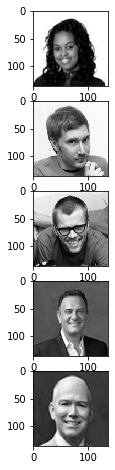

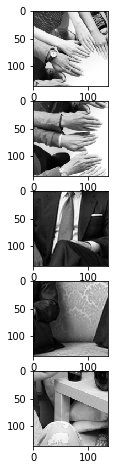

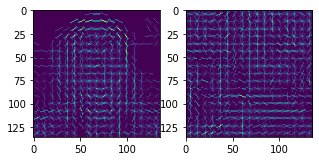

(663, 1105)
(83, 139)


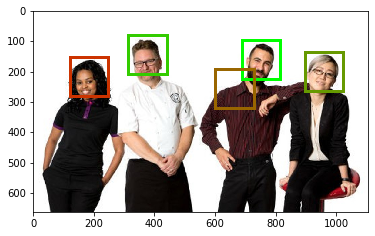

In [14]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos/pos1.jpg','pos/pos2.jpg','pos/pos3.jpg','pos/pos4.jpg','pos/pos5.jpg')
negfiles = ('neg/neg1.jpg','neg/neg2.jpg','neg/neg3.jpg','neg/neg4.jpg','neg/neg5.jpg')

# call learn_template to learn and visualize the template and training data
t = learn_template(posfiles,negfiles,tsize=np.array([17,17]))
               
# call detect on one or more test images, visualizing the result with the plot_detections function
im = plt.imread("images/faces/faces1.jpg")
im_grey = np.average(im, axis=2)

detections = detect(im_grey, t, ndetect=5)
plot_detections(im,detections,tsize_pix)


## Experiment 2: Labrador Face detection

/home/laguna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/laguna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


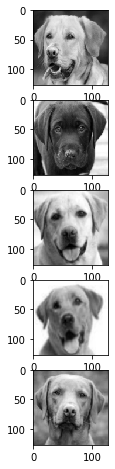

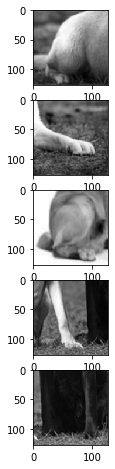

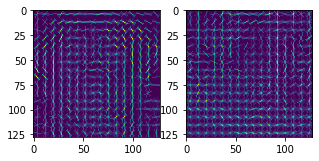

(438, 568)
(55, 71)


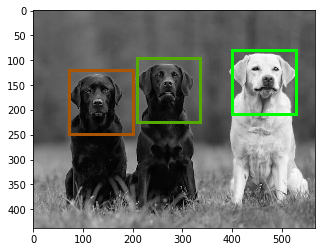

In [17]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos2/pos_1c.jpg','pos2/pos_2c.jpg','pos2/pos_3c.jpg','pos2/pos_4c.jpg','pos2/pos_5c.jpg')
negfiles = ('neg2/neg_1c.jpg','neg2/neg_2c.jpg','neg2/neg_3c.jpg','neg2/neg_4c.jpg','neg2/neg_5c.jpg')

# call learn_template to learn and visualize the template and training data
t = learn_template(posfiles,negfiles,tsize=tsize)
               
# call detect on one or more test images, visualizing the result with the plot_detections function
im = plt.imread("pos2/labs2.jpg")
im = np.average(im, axis=2)

detections = detect(im, t, ndetect=3)
plot_detections(im,detections,tsize_pix)